In [14]:
import typing as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng()
np.set_printoptions(linewidth=180, edgeitems=28, formatter={
    'int': lambda x: f'{x:3}',
    'float': lambda x: f'{x:5.3f}'
})
plt.rcParams['figure.figsize'] = 8,6

In [25]:
TBatch = np.ndarray  # (-1,28,28)
TResult = np.ndarray  # (-1)
TBatchFunction = T.Callable[[TBatch], TResult]
TLabels = T.Tuple[int,int]
TSearchResult = np.ndarray # (number of runs, number of parameters + 1 [parameters tested and score])

In [9]:
labels = [0,1]

image_data_all_df = pd.read_csv('archive/mnist_train.csv')
image_data_all = image_data_all_df[image_data_all_df.label.isin(labels)].to_numpy()
image_data: TBatch = image_data_all[:,1:].reshape((-1,28,28))
label_data: TResult = image_data_all[:,0].reshape(-1)

In [5]:
image_data_all_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def hist_feature(featurizer: TBatchFunction, labels: TLabels):
    f0 = featurizer(image_data[label_data == labels[0]])
    f1 = featurizer(image_data[label_data == labels[1]])

    alpha = .7
    bins=25
    fig,ax = plt.subplots()
    ax.hist(f0, bins=bins, alpha=alpha, color='red', label='f0')
    ax.hist(f1, bins=bins, alpha=alpha, color='blue', label='f1')
    ax.legend()
    return fig, ax

(<Figure size 800x600 with 1 Axes>, <AxesSubplot: >)

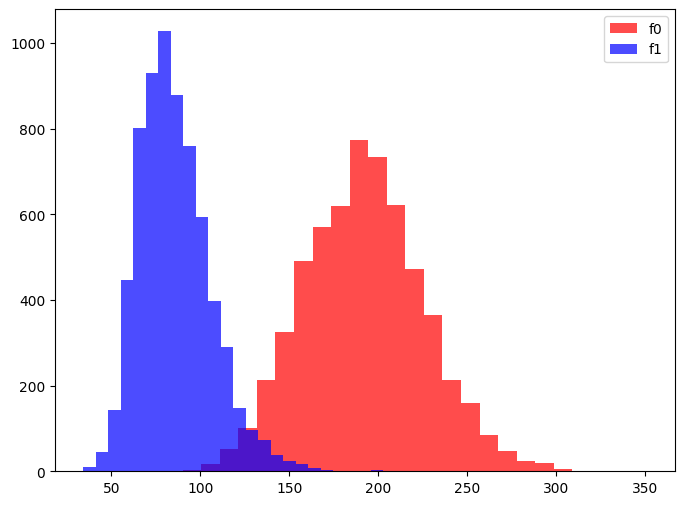

In [15]:
def total_active_cells_feature(X: TBatch) -> TResult:
    return X.clip(min=0,max=1).sum(axis=(1,2)).reshape(-1)

hist_feature(total_active_cells_feature, labels=[0,1])

In [30]:
def accuracy(predictions: TResult, labels: TResult, axis=None) -> np.ndarray:
    return (predictions == labels).mean(axis=axis)

(<Figure size 800x600 with 9 Axes>,
 array([[<AxesSubplot: title={'center': '1: 77'}>, <AxesSubplot: title={'center': '0: 194'}>, <AxesSubplot: title={'center': '0: 175'}>],
        [<AxesSubplot: title={'center': '0: 248'}>, <AxesSubplot: title={'center': '0: 169'}>, <AxesSubplot: title={'center': '0: 193'}>],
        [<AxesSubplot: title={'center': '0: 241'}>, <AxesSubplot: title={'center': '1: 84'}>, <AxesSubplot: title={'center': '0: 174'}>]], dtype=object))

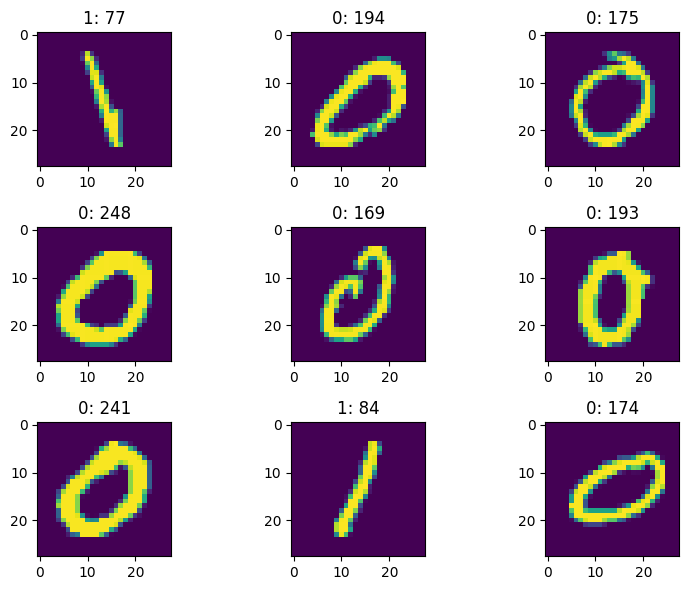

In [19]:
def show_feature_sample(featurizer: TBatchFunction, image_data: TBatch = image_data):
    rows = 3
    columns = 3
    fig, axes = plt.subplots(rows,columns)
    samples = rng.choice(image_data_all, rows*columns)
    images = samples[:,1:].reshape((-1,28,28))
    labels = samples[:,0].reshape(-1)
    features = featurizer(images)
    for i,ax in enumerate(axes.flat):
        title = f'{labels[i]}: {features[i]}'
        ax.imshow(images[i])
        ax.set_title(title)
    fig.tight_layout()
    return fig,axes

show_feature_sample(total_active_cells_feature)

In [72]:
class SingleFeatureBinaryClassifier:
    def __init__(self, featurizer: TBatchFunction, parameter: float, labels: T.Tuple[int, int]):
        self.featurizer = featurizer
        self.parameter = parameter
        self.labels = labels

    def _predict(self, features: np.ndarray, parameter: np.ndarray) -> np.ndarray:
        return np.where(features < parameter, self.labels[0], self.labels[1])

    def predict(self, X: TBatch) -> TResult:
        return self._predict(self.featurizer(X), np.array(self.parameter))

    def score(self, X: TBatch = image_data, y: TResult = label_data) -> float:
        return accuracy(self.predict(X), y)

    def fit(self, X: TBatch = image_data, y: TResult = label_data, n=128) -> TSearchResult:
        features = self.featurizer(image_data)
        f0 = features[label_data == self.labels[0]]
        f1 = features[label_data == self.labels[1]]
        f0_max = f0.max()
        f1_min = f1.min()
        if f0_max < f1_min:
            parameter = np.mean([f0_max, f1_min])
            score = SingleFeatureBinaryClassifier(self.featurizer, parameter, self.labels).score()
            return np.array([parameter, score]).reshape(1, 2)
        parameters = np.linspace(f1_min, f0_max, n)
        predictions_by_row = self._predict(features.reshape((1, -1)), parameters.reshape((-1, 1)))
        assert predictions_by_row.shape == (parameters.shape[0], features.shape[0])
        scores = accuracy(predictions_by_row, label_data.reshape((1, -1)), axis=1)
        self.parameter = parameters[np.argmax(scores.reshape(-1))]
        return np.hstack([parameters.reshape((-1,1)), scores.reshape((-1,1))])


model = SingleFeatureBinaryClassifier(
    featurizer=total_active_cells_feature,
    parameter=125,
    labels=(1, 0),
)

original_parameter, original_score = model.parameter, model.score()
model.fit()
original_parameter, original_score, model.parameter, model.score()


(125, 0.9698381365969206, 131.57480314960628, 0.9722068693249112)

In [ ]:
from itertools import product

def rectangular_partition(array: np.ndarray, xs: T.List[int], ys: T.List[int]):
    result = []
    for i in range(len(xs) - 1):
        for j in range(len(ys) - 1):
            a = array.copy()
            z = np.zeros(a.shape)
            z[ys[j]:ys[j+1],xs[i]:xs[i+1]] = a[ys[j]:ys[j+1],xs[i]:xs[i+1]]
            result.append(z)
    return np.stack(result)

rectangular_partition(np.ones((4,4)),[0,3,4],[0,2,4])

In [42]:
def make_basis(xs: T.List[int], ys: T.List[int]):
    a = np.ones((max(ys),max(xs)))
    return rectangular_partition(a, xs, ys)

In [125]:
class LinearKernelFeaturizer:
    def __init__(self, basis: np.ndarray, coefficients: np.ndarray = None):
        self.basis = basis
        self.coefficients = coefficients if coefficients is not None else np.ones(basis.shape[0])

    def get_kernel(self):
        return (self.coefficients.reshape((-1, 1, 1)) * self.basis).sum(axis=0)

    def fit(
        self, X: TBatch = image_data, y: TResult = label_data, labels: TLabels = labels, n=128
    ) -> TSearchResult:
        coefficients = rng.integers(0, 3, self.basis.shape[0] * n).reshape((n, self.basis.shape[0]))
        kernels = (np.expand_dims(coefficients, (2, 3)) * np.expand_dims(self.basis, 0)).sum(axis=1)
        assert kernels.shape == (n, *X.shape[1:])
        features = (
            np.expand_dims(kernels, 1) * np.expand_dims(image_data.clip(min=0, max=1), 0)
        ).sum(axis=(2, 3))
        f0 = features[:, label_data == labels[0]]
        f1 = features[:, label_data == labels[1]]
        f0_maxs = f0.max(axis=1)
        f1_mins = f1.min(axis=1)
        overlap = (f1 < f0_maxs.reshape((-1, 1))).sum(axis=1) + (f0 > f1_mins.reshape((-1, 1))).sum(
            axis=1
        )
        self.coefficients = coefficients[np.argmin(overlap)]
        return np.hstack([coefficients, overlap.reshape((-1, 1))])

    def __call__(self, X: TBatch) -> TResult:
        kernel = self.get_kernel()
        return (X.clip(min=0, max=1) * np.expand_dims(kernel, 0)).sum(axis=(1, 2))


n_kernel = 64
n_model = 16
basis = make_basis([0, 9, 14, 19, 28], [0, 10, 15, 20, 28])
linear_kernel_featurizer = LinearKernelFeaturizer(basis)
kernel_search_result = linear_kernel_featurizer.fit(n=n_kernel, labels=[1, 0])

sorted_kernel_search_results = kernel_search_result[np.argsort(kernel_search_result[:, -1])]
# top_kernel_search_results = np.flip(sorted_kernel_search_results, axis=0)[:n]
top_kernel_search_results = sorted_kernel_search_results[:n_model]
models = []

for result in top_kernel_search_results:
    model = SingleFeatureBinaryClassifier(
        featurizer=LinearKernelFeaturizer(basis=basis, coefficients=result[0:-1]),
        parameter=100,
        labels=[1, 0],
    )
    model_search_result = model.fit()
    models.append((model, model.score(), model_search_result))

(
    top_kernel_search_results,
    linear_kernel_featurizer.coefficients,
    # [s for m, s, h in models],
    (model.parameter, model.score()),
    [(t[0].featurizer.coefficients, np.flip(t[2][np.argsort(t[2][:, 1])])[:3]) for t in models],
)


(array([[  1,   2,   0,   1,   0,   2,   0,   0,   0,   1,   0,   1,   1,   2,   2,   0, 4046],
        [  0,   1,   2,   2,   1,   2,   2,   1,   0,   0,   0,   0,   0,   2,   1,   2, 4100],
        [  1,   0,   2,   2,   0,   2,   1,   2,   0,   1,   0,   2,   0,   2,   2,   1, 4319],
        [  0,   1,   1,   2,   2,   1,   1,   1,   1,   0,   0,   0,   0,   1,   0,   0, 4555],
        [  1,   0,   2,   0,   1,   2,   1,   2,   1,   0,   0,   1,   1,   2,   2,   2, 4810],
        [  2,   1,   2,   2,   1,   0,   2,   2,   2,   0,   0,   1,   0,   2,   2,   1, 5064],
        [  0,   2,   0,   2,   2,   1,   1,   0,   0,   0,   0,   1,   1,   2,   1,   1, 5744],
        [  1,   0,   2,   2,   2,   2,   1,   2,   2,   0,   2,   0,   2,   2,   0,   1, 5757],
        [  1,   1,   0,   1,   2,   2,   1,   2,   1,   0,   1,   2,   2,   1,   2,   0, 6162],
        [  0,   2,   2,   1,   0,   0,   0,   0,   1,   0,   0,   0,   1,   0,   1,   1, 6415],
        [  2,   2,   1,   2,   1,   2,  

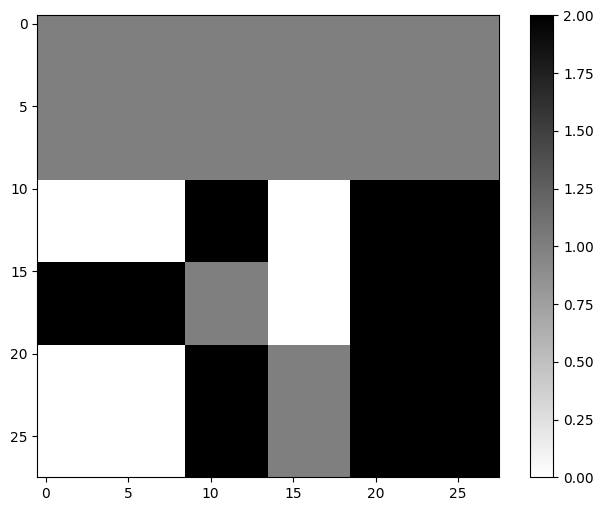

In [130]:
linear_kernel_featurizer = LinearKernelFeaturizer(
    basis=basis,
    coefficients=np.array([1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 2]),
)

plt.imshow(linear_kernel_featurizer.get_kernel(), cmap="binary")
plt.colorbar()
